This is a mini project for Machine Vision. Here the goal is an image classifier

In [65]:
 # pip install split-folders # Remove the first hashtag to run this command if split-folders is not installed.

In [ ]:
import splitfolders
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np





In [67]:
'''path = kagglehub.dataset_download(
    "hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images"
)
print("Path to dataset files:", path)'''
# Setting the directory paths
path = "/Users/E1012131/Downloads/Shoe vs Sandal vs Boot Dataset"

In [68]:
# Setting the directory paths
source_dir = Path(path) # Source directory of the dataset
dest_dir = Path("/Users/E1012131/Downloads/spit_data") # Destination directory for organized dataset
# dest_dir is where the split dataset will be saved. Change it to your desired path.
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [69]:
# Splitting the dataset into training, validation, and test sets
splitfolders.ratio(
    source_dir,
    output=dest_dir,
    seed=42,
    ratio=(train_size, val_size, test_size),
    group_prefix=None,
)

Copying files: 15000 files [00:17, 865.66 files/s] 


In [70]:
# Definition of paths and paramerters
Train_dir = f"{dest_dir}/train"
Val_dir = f"{dest_dir}/val"
Test_dir = f"{dest_dir}/test"

img_size = (224, 224)
Batch_size = 32
Num_classes = 3


In [71]:
# Loading images from the destination directory and assigning labels automatically with keras
train_ds = tf.keras.utils.image_dataset_from_directory(
    Train_dir,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical" # for one hot labels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    Val_dir,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    Test_dir,
    image_size=img_size,
    batch_size=Batch_size,
    label_mode="categorical"
)

Found 10500 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.
Found 2250 files belonging to 3 classes.


In [72]:
# Here we normalize the pixel values for training, val, and test images
normalization_layer = layers.Rescaling(1/255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [73]:
# Data Augmentation on training set of images
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [ ]:
# Building the CNN using transferlearning of pretrained model ResNet50

base_model = ResNet50(
    input_shape=img_size + (3,), 
    include_top=False, 
    weights="imagenet",
    pooling="max"
)

base_model.trainable = False


In [ ]:
# Classifier head 

model = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input, name="resnet_preprocess"),
    base_model,
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(Num_classes, activation="softmax")
])

In [81]:
# Model compilation

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [82]:
# Train the model and use early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 292s 871ms/step - accuracy: 0.9061 - loss: 0.2515 - val_accuracy: 0.9564 - val_loss: 0.1190
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 269s 816ms/step - accuracy: 0.9385 - loss: 0.1695 - val_accuracy: 0.9640 - val_loss: 0.0991
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 314s 793ms/step - accuracy: 0.9493 - loss: 0.1427 - val_accuracy: 0.9671 - val_loss: 0.0960
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 274s 833ms/step - accuracy: 0.9535 - loss: 0.1313 - val_accuracy: 0.9742 - val_loss: 0.0824
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 276s 838ms/step - accuracy: 0.9558 - loss: 0.1209 - val_accuracy: 0.9698 - val_loss: 0.0842
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 271s 824ms/step - accuracy: 0.9552 - loss: 0.1230 - val_accuracy: 0.9684 - val_loss: 0.0846
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 242s 734ms/step - accuracy: 0.9624 - loss: 0.1048 - val_accuracy: 0.9742 - val_loss: 0.0745
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 264s 739ms/step - accuracy: 0.9625 -

<function matplotlib.pyplot.show(close=None, block=None)>

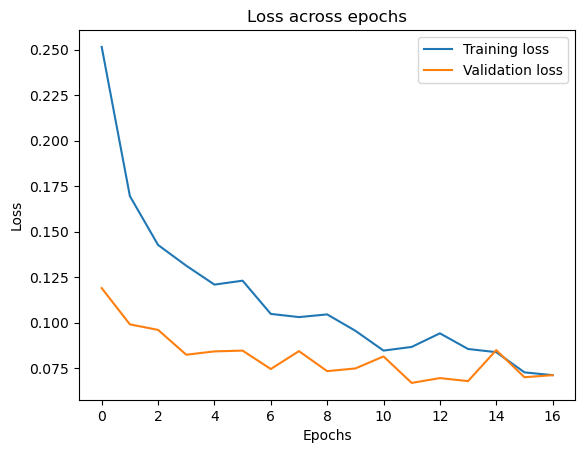

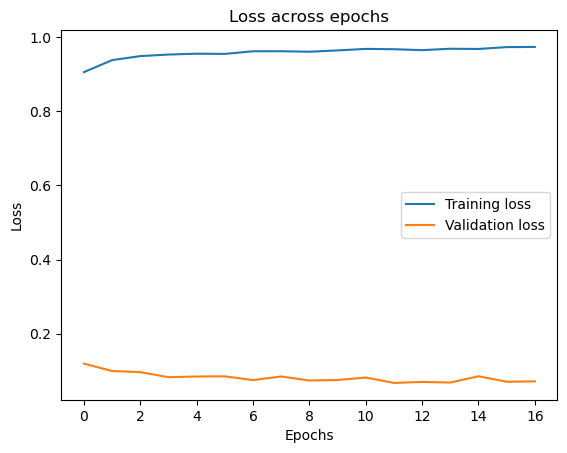

In [ ]:
# Loss and accuracy graph analysis
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss across epochs")
plt.show

plt.figure()
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy across epochs")
plt.show


best_epoch = int(np.argmin(history.history["val_loss"]))
best_val = float(np.min(history.history["val_loss"]))
print(f"Best val_loss = {best_val:.4f} at epoch {best_epoch}")

In [84]:
# Evaluate on the test set 
'''
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")
'''

'\ntest_loss, test_acc = model.evaluate(test_ds)\nprint(f"Test accuracy: {test_acc:.3f}")\n'

In [85]:
# using confusion matrix to tell what the model confuses and why the model might fail giving insights for tuning
'''
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

print(confusion_matric(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["shoe", "boot", "sandal"]))
'''

'\ny_true = np.concatenate([y for x, y in test_ds], axis=0)\ny_pred = model.predict(test_ds)\n\ny_true = np.argmax(y_true, axis=1)\ny_pred = np.argmax(y_pred, axis=1)\n\nprint(confusion_matric(y_true, y_pred))\nprint(classification_report(y_true, y_pred, target_names=["shoe", "boot", "sandal"]))\n'

In [87]:
# Saving the model to preserve architecture, weights, and preprocessing layers
'''
model.save(shoe_boot_sandal_cnn)
'''

'\nmodel.save(shoe_boot_sandal_cnn)\n'

In [ ]:
'''
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Predicted: {preds.argmax()}, True: {labels[0].numpy()}")
    plt.show()
'''